# Predicting Formation Tops from Well Log Data using CNN

CNNs are powerful tools for pattern recognition and feature extraction in various types of data, including images, time-series, and, in your case, geological log curve data. Here's why they are suitable for this task:

<b>Feature Extraction:</b> CNNs can automatically learn and extract relevant features from the input data. In your scenario, the model can learn to identify patterns in gamma ray, resistivity, and density porosity curves that are indicative of formation tops.

<b>Spatial Hierarchy:</b> CNNs can capture the hierarchical spatial structures present in the data. This is crucial for understanding the geological layers and their properties.

<b>Translation Invariance:</b> CNNs are robust to shifts and distortions in the input data, which is beneficial when dealing with natural variations in geological formations.
Efficient Parameter Usage: CNNs share weights across different parts of the input, making them more parameter-efficient compared to fully connected networks. This is especially useful when dealing with large datasets.

In [311]:
import tensorflow as tf
from keras import layers, models
from keras.layers import Normalization, Lambda
from keras.models import load_model
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.regularizers import l2
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

## U-Net Architecture

The U-Net architecture is a type of convolutional neural network that was originally designed for biomedical image segmentation. The combination of global and local views in a U-Net architecture allows the model to understand both the broader context and the finer details of the input data, which is crucial for tasks like predicting formation tops in geological data. Here are common parts of a U-Net architecture
- Contracting Path: The contracting path is similar to a typical convolutional network. It consists of repeated application of convolutions, followed by a rectified linear unit (ReLU) and a max pooling operation. With each downsampling step, the network increases the number of feature channels.

- Expansive Path: The expansive path consists of upsampling of the feature map followed by a convolution ("up-convolution"), which halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two more convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

- Skip Connections: The key innovation in U-Net is the use of skip connections, where outputs from the contracting path are concatenated with inputs to the expansive path. These connections provide the expansive path with the context information lost during downsampling, which is crucial for precise localization.

### Global View 

The global view in a U-Net architecture refers to the initial layers of the network where the input data is progressively downsampled (pooled). The purpose of the global view is to:

<b>Capture Context:</b> By looking at the broader picture, the global view helps the model understand the overall context of the data. In geological terms, this might mean understanding the general trends and structures across a wide depth range.

<b>Reduce Dimensionality:</b> Pooling layers reduce the spatial dimensions of the feature maps, which decreases the computational complexity and helps in focusing on the more salient features.

<b>Increase Receptive Field:</b> As the data is downsampled, the receptive field of the neurons increases, allowing them to capture more global features that are relevant for the prediction task.

In [312]:
def inception_module(input_tensor, filter_channels, dilation3x3=32, dilation5x5=24,dilation7x7=24):
    
    # Branch 1: 1x1 conv
    branch1x1 = layers.Conv1D(filter_channels, 1, padding='same', activation='relu')(input_tensor)
    
    # Branch 2: 1x1 conv followed by 3x3 conv
    branch3x3 = layers.Conv1D(filter_channels, 1, padding='same', activation='relu')(input_tensor)
    branch3x3 = layers.Conv1D(filter_channels, 3, padding='same', activation='relu', dilation_rate=dilation3x3)(branch3x3)
    
    # Branch 2: 1x1 conv followed by 3x3 conv
    branch5x5 = layers.Conv1D(filter_channels//2, 1, padding='same', activation='relu')(input_tensor)
    branch5x5 = layers.Conv1D(filter_channels//2, 5, padding='same', activation='relu', dilation_rate=dilation5x5)(branch5x5)
    
    pool3x3 = layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool3x3 = layers.Conv1D(filter_channels//2, 1, padding='same', activation='relu')(pool3x3)
    
    # # Branch 2: 1x1 conv followed by 3x3 conv
    # branch7x7 = layers.Conv1D(filter_channels//2, 1, padding='same', activation='relu')(input_tensor)
    # branch7x7 = layers.Conv1D(filter_channels//2, 7, padding='same', activation='relu', dilation_rate= dilation7x7)(branch7x7)
    
        
    # Concatenate all the branches
    concatenated = layers.Concatenate(axis=-1)([ branch3x3, branch5x5,branch1x1,pool3x3])
    
    return concatenated


In [313]:
def create_global_view(initial_layer = 4, dropout = 0.2, dilation3x3 =32,dilation5x5=24,dilation7x7=24):
    inputs = layers.Input(shape=(None, 4))  # Assuming the logs are 1D sequences
    x = layers.Masking(mask_value=-99)(inputs)  # Using -99 as the mask value
    
    # Encoding layer 1
    conv1 = inception_module(x, initial_layer, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout)(conv1)
    pool1 = layers.AveragePooling1D()(conv1)

    # Encoding layer 2
    conv2 = inception_module(pool1, initial_layer*2, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Dropout(dropout)(conv2)
    pool2 = layers.AveragePooling1D()(conv2)

    # Middle layer
    conv_middle = inception_module(pool2,initial_layer*4, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    conv_middle = layers.BatchNormalization()(conv_middle)
    conv_middle = layers.Dropout(dropout)(conv_middle)
    

    # Decoding layer 1
    up1 = layers.UpSampling1D()(conv_middle)
    merge1 = layers.concatenate([conv2, up1]) 
    # merge1 = layers.concatenate([conv1, up1])
    
    decode1 = inception_module(merge1,initial_layer*2, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    decode1 = layers.BatchNormalization()(decode1)
    decode1 = layers.Dropout(dropout)(decode1)
    # Decoding layer 2
    up2 = layers.UpSampling1D()(decode1)
    
    # Ensure sizes match before concatenating for the second merge
    merge2 = layers.concatenate([conv1, up2])

    decode2 = inception_module(merge2, initial_layer, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    decode2 = layers.BatchNormalization()(decode2)
    decode2 = layers.Dropout(dropout)(decode2)
    
    # output = layers.Activation(activation="tanh")(decode2)

    return models.Model(inputs, decode2)

### Local View

The local view, are specialized layers like inception modules with dilated convolutions, focuses on finer details. Its purposes include:

Detail Preservation: The local view helps in preserving and highlighting the finer details and local features that might be crucial for accurate prediction of formation tops.
High-Resolution Feature Maps: As the data is upsampled or processed through dilated convolutions, the feature maps regain their resolution, allowing the model to make more precise localizations.


In [314]:
def create_local_view(initial_filters=2, input_shape=(None, 4), mask_value=-99, dilation3x3 =32,dilation5x5=24,dilation7x7=24):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Masking layer
    x = layers.Masking(mask_value=mask_value)(inputs)
    
    conv1 = inception_module(x,initial_filters, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    
    conv2 = inception_module(conv1,initial_filters, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    
    # conv3 = inception_module(conv2,initial_filters)
    
    # output = layers.Conv1D(1, kernel_size=1, padding='same', activation='tanh')(conv2)
    
    return models.Model(inputs, conv2)

## Data Preparation for U-Net Model

Our U-Net model requires the input data to adhere to specific dimensional constraints for it to process the data effectively. To ensure compatibility with the model's architecture, we perform the following preprocessing steps on each well's log data:

### Normalization
Firstly, we normalize the data to ensure that the model receives inputs that are on a similar scale. This is crucial for the model's convergence and performance. The normalization is performed using the following formula:

$$ \text{normalized\_data} = \frac{\text{data} - \text{mean}}{\text{std}} $$

where `mean` and `std` are the mean and standard deviation of the training data, respectively.

### Ensuring Even Length
The U-Net architecture involves multiple layers of downsampling and upsampling. To avoid any off-by-one errors during these operations, we need to ensure that the input data's length is even and remains even when divided by 2 and 4. We achieve this by:

1. **Appending Padding**: If the sequence length is odd, we append a padding row to make it even. This padding is set to a specific value (e.g., -99) that the model can recognize and ignore during processing.

2. **Adjusting Maximum Length**: We calculate the maximum length across all sequences and adjust it to ensure that it is even and divisible by 2 and 4. This adjustment is necessary to maintain the integrity of the data's spatial dimensions throughout the U-Net's downsampling and upsampling pathways.

3. **Padding to Maximum Length**: Finally, we pad all sequences to this adjusted maximum length. This uniformity is essential for batch processing and allows the model to process multiple sequences simultaneously.

By adhering to these preprocessing steps, we ensure that our U-Net model receives well-formatted input data, which is crucial for accurate predictions. The padding added during these steps is carefully handled by the model and does not significantly impact its predictive performance.

### Gaussian Smoothing
Gaussian smoothing is a technique that is particularly useful for addressing data imbalance issues in machine learning tasks, especially when dealing with time series or spatial data. When you have a dataset with a binary classification problem and one class (like well top selection) is significantly underrepresented, this can lead to a model that doesn't perform well on the minority class because it hasn't had enough examples to learn from. This will create a gaussian kernal around the top selection to help make the mdoel mroe accurate

## Model Training

In this section, we define and train our U-Net model for the task of predicting formation tops in geological data. The model utilizes a combination of global and local views to capture both the broader context and fine details necessary for accurate predictions.

### Binary Cross entropy

Binary Cross-Entropy, also known as log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. It's a commonly used loss function for binary classification tasks. Binary Cross-Entropy loss increases as the predicted probability diverges from the actual label, being more punitive for predictions that are confidently incorrect.

### Model Architecture

The model architecture combines the outputs of the global and local views using a multiplication operation. This combined output is then passed through a soft attention mechanism, implemented using a tanh activation function, to highlight the regions of interest. The final output is obtained using a 1D convolutional layer with a sigmoid activation function, which provides the probability of a formation top at each depth.

### Training Process
The model is trained using the Adam optimizer and the focal loss function. We employ an early stopping mechanism to prevent overfitting, where training is halted if the validation loss does not improve for a specified number of epochs (patience). The training and validation losses are plotted at the end of the training process to visualize the model's learning progress.

During training, each well's log data is processed in batches. The model is trained on each batch, and the losses are recorded. The training loop also includes a validation step to monitor the model's performance on unseen data.

In [315]:
def train_model(X_train, y_train, X_val, y_val, learning_rate, epochs, nodes, dropout, dilation3x3 =32,dilation5x5=24,dilation7x7=24):
    global_view = create_global_view(initial_layer=nodes,dropout = dropout, dilation3x3=dilation3x3, dilation5x5=dilation5x5,dilation7x7=dilation7x7)
    local_view = create_local_view(initial_filters=nodes,dilation3x3=1, dilation5x5=1,dilation7x7=1)
    
    global_output = global_view.output
    local_output = local_view.output
     
    # Apply tanh activation to both global and local views
    activated_global_view = layers.Activation('sigmoid')(global_output)
    # activated_local_view = layers.Activation('sigmoid')(local_output)
    
    activated_local_view = local_output

    # Element-wise multiplication of the activated global and local views
    combined_features = layers.Multiply()([activated_global_view, activated_local_view])
    
    # combined_features=  layers.Multiply()([tf.tanh(global_output), tf.sigmoid(local_output)])
    

    # HYPERPARAMETER: Adjust the number of filters (1) and kernel size (1)
    output = layers.Conv1D(1, 1, activation="sigmoid")(combined_features)

    model = models.Model([global_view.input, local_view.input], output)
    optimizer = Adam()
    
    # HYPERPARAMETER: Adjust the optimizer ('adam') and its parameters
    model.compile(optimizer=optimizer, loss= tf.losses.BinaryCrossentropy())


    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    
    # We'll only use this training loop and remove the redundant one.
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        epoch_train_losses = []
        for i in range(len(X_train)):
            X_train_well = X_train[i].reshape(1, X_train[i].shape[0], X_train[i].shape[1])
            y_train_well = y_train[i].reshape(1, y_train[i].shape[0], 1)
           
            loss = model.train_on_batch([X_train_well, X_train_well], y_train_well)  # Capturing the loss
            epoch_train_losses.append(loss)
        mean_train_loss = np.mean(epoch_train_losses)
        train_losses.append(np.mean(mean_train_loss))

        # Validation (optional)
        epoch_val_losses = []
        for i in range(len(X_val)):
            X_val_well = X_val[i].reshape(1, X_val[i].shape[0], X_val[i].shape[1])
            y_val_well = y_val[i].reshape(1, y_val[i].shape[0], 1)
            loss = model.test_on_batch([X_val_well, X_val_well], y_val_well)
            epoch_val_losses.append(loss)
        mean_val_loss = np.mean(epoch_val_losses)
        val_losses.append(mean_val_loss)
        print(f"Training Loss: {train_losses[-1]:.5f}, Validation Loss: {mean_val_loss:.5f}")

        # Early stopping check
        if (best_val_loss - mean_val_loss) > min_delta:
            best_val_loss = mean_val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.5f}")
                break

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()
    
    return model

In [316]:
# def normalize_data(np_array):
#     # Replace 'inf' with 'NaN' (if needed)
#     np_array[np_array == np.inf] = np.nan
#     np_array[np_array == -np.inf] = np.nan

#     # Impute NaN values with the minimum non-NaN value in each column
#     for i in range(np_array.shape[1]):  # Iterate over columns
#         min_non_nan = np.nanmin(np_array[:, i])
#         np_array[:, i] = np.nan_to_num(np_array[:, i], nan=min_non_nan)

#     # Compute mean and std dev, avoiding division by zero
#     mean = np.mean(np_array, axis=0)
#     std = np.std(np_array, axis=0)
#     std[std == 0] = 1  # Set 0 std dev to 1 to avoid division by zero

#     # Normalize data
#     normalized_array = (np_array - mean) / std

#     return normalized_array

def normalize_data(df, features):
    # Compute mean and std only for specified features
    mean = df[features].mean()
    std = df[features].std()

    # Apply normalization only to the specified features
    df[features] = (df[features] - mean) / std

    return df


def ensure_even_length(sequence, padding_value=-99):
    current_rows = sequence.shape[0]

    # Calculate the number of rows needed to make it a multiple of 8
    rows_needed_to_multiple_of_8 = 8 - (current_rows % 8)

    # Determine the total rows needed
    total_rows_needed = rows_needed_to_multiple_of_8

    if total_rows_needed > 0:
        # Create padding with the same number of columns as the sequence
        padding_shape = (total_rows_needed,) + sequence.shape[1:]
        padding = np.full(padding_shape, padding_value)

        # Append padding to the sequence
        sequence = np.vstack([sequence, padding])

    return sequence

def pad_to_max_length(sequence, max_length, padding_value=-99):
    padding = [(0, max_length - sequence.shape[0]), (0, 0)]
    return np.pad(sequence, padding, mode='constant', constant_values=padding_value)


def adjust_max_length(max_length):
    last_digit = max_length % 10
    
    if last_digit in [2, 6]:
        return max_length + 2
    elif last_digit == 0:
        return max_length + 4
    else:
        return max_length
    
def smooth_labels(y, sigma=2):
    # Ensure y is a 1D array
    y = y.flatten()
    smoothed_y = np.zeros_like(y, dtype=float)
    for idx in np.where(y == 1)[0]:
        gaussian = np.exp(-0.5 * ((np.arange(len(y)) - idx) / sigma) ** 2)
        gaussian /= gaussian.sum()
        smoothed_y += 5.1*gaussian  # Both are 1D arrays, so this should work
    smoothed_y = np.clip(smoothed_y, None, 1)
    return smoothed_y

def pad_np_array(np_array, desired_length, padding_value=-99):
    # Calculate the number of rows to add
    num_rows_to_add = desired_length - np_array.shape[0]

    # If the array is already longer or equal to the desired length, return the original array
    if num_rows_to_add <= 0:
        return np_array

    # Create a new array with the required number of rows filled with the padding value
    padding_array = np.full((num_rows_to_add, np_array.shape[1]), padding_value)

    # Concatenate the original array with the padding array
    padded_array = np.concatenate([np_array, padding_array], axis=0)

    return padded_array

def pad_dataframe(df, desired_length, padding_value=-99):
    # Calculate the number of rows to add
    num_rows_to_add = desired_length - len(df)
    
    # If the dataframe is already longer or equal to the desired length, return the original dataframe
    if num_rows_to_add <= 0:
        return df
    
    # Create a new dataframe with the required number of rows filled with the padding value
    padding_df = pd.DataFrame(padding_value, index=range(num_rows_to_add), columns=df.columns)
    
    # Concatenate the original dataframe with the padding dataframe
    padded_df = pd.concat([df, padding_df], axis=0).reset_index(drop=True)
    
    return padded_df

def check_for_nans(array, name="Array"):
    if isinstance(array, list):
        # Handle case where array is a list of arrays
        for i, arr in enumerate(array):
            if np.isnan(arr).any():
                nan_rows = np.any(np.isnan(arr), axis=1)
                print(f"NaNs found in {name} at array index {i}. Rows with NaNs:")
                print(arr[nan_rows])
    else:
        # Handle case where array is a single NumPy array
        if np.isnan(array).any():
            nan_rows = np.any(np.isnan(array), axis=1)
            print(f"NaNs found in {name}. Rows with NaNs:")
            print(array[nan_rows])
            
            
def check_for_nans_in_dataframe(df, name="DataFrame"):
    # Check if the DataFrame contains any NaN values
    if df.isna().any().any():
        # Get rows which contain NaNs
        rows_with_nans = df[df.isna().any(axis=1)]
        print(f"NaNs found in {name}. Rows with NaNs:")

In [317]:
def get_train_data(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    max_length = 0
    dfs = []
    for file in files:
        df = pd.read_csv(folder_path + file)
        if len(df.index)>max_length:
            max_length = len(df.index)
        check_for_nans_in_dataframe(df,name = file)
        dfs.append(df)
    
    
    train_dfs, val_dfs = train_test_split(dfs, test_size=0.2, random_state=42) # Here 20% of the data is kept for validation

    features = ["VSH", "RESD", "DPHI", "NPHI"]
    
    # Normalize data 
    train_dfs = [normalize_data(df,features) for df in train_dfs]
    val_dfs = [normalize_data(df,features) for df in val_dfs]
    
    # The CNN model requires each well log to be of the same shape and the shape needs to be a multiple of 8 or it will cause an error
    
    # Pad to max_length with -99 as none of the logs will have this as a value
    train_dfs = [pad_dataframe(df, max_length) for df in train_dfs]
    val_dfs = [pad_dataframe(df, max_length) for df in val_dfs]
    

    # Extract features and labels for training and validation sets
    X_train = np.array([df[features].values for df in train_dfs])
    y_train = np.array([df["Pick"].values for df in train_dfs])

    X_val = np.array([df[features].values for df in val_dfs])
    y_val = np.array([df["Pick"].values for df in val_dfs])
    
    # Ensure the input is not only even but a multiple of 8 so that the CNN Model can handle it. NOTE that that afterwards there might be a new max length
    X_train = [ensure_even_length(x) for x in X_train]
    X_val = [ensure_even_length(x) for x in X_val]

    # Compute max_length again after ensuring a multiple of 8 lengths. 
    max_length2 = max(max(x.shape[0] for x in X_train), max(x.shape[0] for x in X_val))

    # Pad to new max_length
    X_train = [pad_to_max_length(x, max_length2) for x in X_train]
    X_val = [pad_to_max_length(x, max_length2) for x in X_val]

    # apply gaussian kernal to y values
    y_train = [smooth_labels(y) for y in y_train]
    y_val = [smooth_labels(y) for y in y_val]

    # Ensure even length for labels and then pad
    y_train = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_train]
    y_val = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_val]
    
    
    # Now we need to pad the y values. The y values will be padded with 0 as they are not the picks
    y_train = [pad_to_max_length(y, max_length2,padding_value=0) for y in y_train]
    y_val = [pad_to_max_length(y, max_length2,padding_value=0) for y in y_val]
    
    [check_for_nans(x, "X_train array "+ str(i)) for i, x in enumerate(X_train)]
    [check_for_nans(x, "X_val array " + str(i)) for i, x in enumerate(X_val)]
    [check_for_nans(x, "y_train array " + str(i)) for i, x in enumerate(y_train)]
    [check_for_nans(x, "y_val array " + str(i)) for i, x in enumerate(y_val)]
    
    return X_train, y_train, X_val, y_val

In [318]:
def get_test_data(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    test_dfs = []
    max_length = 0
    for file in files:
        df = pd.read_csv(folder_path + file)
        if len(df.index)>max_length:
            max_length = len(df.index)
        test_dfs.append(df)

    features = ["VSH", "RESD", "DPHI", "NPHI"]
    
    # Normalize data
    
    test_dfs = [normalize_data(df,features) for df in test_dfs]
    
    # The CNN model requires each well log to be of the same shape and the shape needs to be a multiple of 8 or it will cause an error
    
    # Pad INPUT to max_length with -99 as none of the logs will have this as a value
    
    test_dfs = [pad_dataframe(df, max_length) for df in test_dfs]
    
    # Extract features and labels for training and validation sets
    X_test = np.array([df[features].values for df in test_dfs])
    y_test = np.array([df["Pick"].values for df in test_dfs])

    # Ensure multiple of 8 for UNET
    X_test = [ensure_even_length(x) for x in X_test]
    
    # Compute NEW max_length after ensuring lengths OF MULTIPLE OF 8
    max_length2 = max(x.shape[0] for x in X_test)
    
    # Pad to max_length
    X_test = [pad_to_max_length(x, max_length2) for x in X_test]
    
    # apply gaussian kernal to y values
    y_test = [smooth_labels(y) for y in y_test]
    
    # Ensure even length for labels and then pad
    y_test = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_test]
    
    y_test = [pad_to_max_length(y, max_length2,padding_value=0) for y in y_test]
    
    test_dfs = [pad_dataframe(df, max_length2,padding_value=-99) for df in test_dfs]
    
    # # Update the 'Pick' column in test_dfs with y_test values
    # for i, df in enumerate(test_dfs):
    #     df['Pick'] = y_test[i][:len(df)]  # Assuming y_test[i] is already the correct length
    
    [check_for_nans(x, "X_test " + str(i)) for i, x in enumerate(X_test)]
    [check_for_nans(x, "y_test " + str(i)) for i, x in enumerate(y_test)]
    
    return X_test, y_test, test_dfs


In [319]:
def make_predictions(test_df, X_test,y_test, model, formation_test_data):
    x_reshape = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
    predictions = model.predict([x_reshape, x_reshape])
    
    # Flatten the predictions to 1D array for easier indexing
    predictions_flat = predictions.flatten()
    
    # Initialize binary_predictions to all zeros
    binary_predictions = np.zeros_like(predictions_flat, dtype=int)
    
    # Find the index of the maximum prediction probability
    max_prob_index = np.argmax(predictions_flat)
    
    # Set only the max index to 1
    binary_predictions[max_prob_index] = 1
    
    test_df['Binary_Predict'] = binary_predictions.flatten()
    test_df['Predict'] = predictions.flatten()
    test_df['Acutal Pick']=y_test.flatten()
    name=test_df['SitID'][0]
    
    os.makedirs(formation_test_data+"/Predictions", exist_ok=True)
    # Save the DataFrame as a CSV file
    output_path = os.path.join(formation_test_data+"/Predictions", f"predictions_{name}.csv")
    test_df.to_csv(output_path, index=False)
    
    

## Model Evaluation on Test Data

After training our model, it's crucial to evaluate its performance on data that it has never seen before, also known as the test data. This step helps us understand how well the model generalizes to new, unseen examples. We use several metrics for this evaluation: Precision, Recall, and the F1 Score.

### Evaluation Metrics

- **Precision**: This metric tells us the proportion of positive identifications that were actually correct. It is defined as the number of true positives divided by the number of true positives plus the number of false positives.

- **Recall**: Also known as sensitivity, this metric tells us the proportion of actual positives that were identified correctly. It is defined as the number of true positives divided by the number of true positives plus the number of false negatives.

- **F1 Score**: This is the harmonic mean of Precision and Recall and gives a combined measure of the two metrics. It is particularly useful when the class distribution is imbalanced.

### Tolerance Window (`delta_T_depth`)

Due to the nature of geological data, the exact pinpointing of formation tops might not be feasible. Therefore, we introduce a tolerance window, `delta_T_depth`, which allows for a small margin of error in the predictions based on depth values (e.g., meters). This tolerance window accounts for the fact that the model's predictions might be a few meters away from the actual formation tops.

### Evaluation Process

We loop over different values of `delta_T_depth` to understand how the model's performance varies with different levels of strictness in the predictions. For each `delta_T_depth` value, we calculate the Precision, Recall, and F1 Score for each well log in the test dataset based on the depth values. We then compute the average of these metrics across all well logs to get an overall understanding of the model's performance.

The code snippet below demonstrates this evaluation process based on depth values:

In [320]:
def evaluate_model(test_dfs):
    metrics_at_delta_T = {}
    # Initialize lists to store metrics for each well log
    all_precisions = []
    all_recalls = []
    all_F1_scores = []

    # Define the different delta_T values in terms of depth (e.g., meters)
    delta_T_depth_values = [0.5, 1, 2, 3, 6]  # Example values in meters

    # Loop over each delta_T value
    for delta_T_depth in delta_T_depth_values:
        # Initialize lists to store metrics for each well log
        all_precisions = []
        all_recalls = []
        all_F1_scores = []

        # Loop over each well log
        for i in range(len(test_dfs)):
            ground_truth_depths = test_dfs[i].loc[test_dfs[i]['Pick'] == 1, 'DEPT']  # Depths of actual formation tops
            prediction_depths = test_dfs[i].loc[test_dfs[i]['Binary_Predict'] == 1, 'DEPT']  # Depths of predicted formation tops

            # 2. Precision
            true_positives = sum(np.any(np.abs(gt_depth - prediction_depths) <= delta_T_depth) for gt_depth in ground_truth_depths)
            prec = true_positives / len(prediction_depths) if len(prediction_depths) > 0 else 0
            all_precisions.append(prec)

            # 3. Recall
            detected_tops = sum(np.any(np.abs(gt_depth - prediction_depths) <= delta_T_depth) for gt_depth in ground_truth_depths)
            rec = detected_tops / len(ground_truth_depths) if len(ground_truth_depths) > 0 else 0
            all_recalls.append(rec)

            # 4. F1 Score
            if prec + rec > 0:  # Avoid division by zero
                F1 = 2 * (prec * rec) / (prec + rec)
            else:
                F1 = 0
            all_F1_scores.append(F1)

        # Compute average metrics across all well logs
        average_precision = np.mean(all_precisions)
        average_recall = np.mean(all_recalls)
        average_F1_score = np.mean(all_F1_scores)

        # Print the average metrics for the current delta_T_depth
        print(f"Metrics for delta_T_depth = {delta_T_depth}m:")
        print("Average Precision:", average_precision)
        print("Average Recall:", average_recall)
        print("Average F1 Score:", average_F1_score)
        print("----------")
        
         # Store the metrics for the current delta_T_depth in the dictionary
        metrics_at_delta_T[delta_T_depth] = {
            'average_precision': average_precision,
            'average_recall': average_recall,
            'average_f1': average_F1_score
        }
    return metrics_at_delta_T

In [321]:
current_dir = os.getcwd()
# Train your model here
folder_path = current_dir + "/Data/Formation_DATA/"

formations = os.listdir(folder_path)
formations = sorted(formations, key=lambda x: int(x))
print(formations)

['1000', '2000', '3000', '4000', '5000', '6000', '7000', '9000', '9500', '10000', '11000', '12000', '13000', '14000']


In [322]:
# # def check_for_nans(array, name="Array"):
# #     if isinstance(array, list):
# #         # Handle case where array is a list of arrays
# #         for i, arr in enumerate(array):
# #             if np.isnan(arr).any():
# #                 nan_indices = np.argwhere(np.isnan(arr))
# #                 print(f"NaNs found in {name} at array index {i}, positions:\n {nan_indices}")
# #     else:
# #         # Handle case where array is a single NumPy array
# #         if np.isnan(array).any():
# #             nan_indices = np.argwhere(np.isnan(array))
# #             print(f"NaNs found in {name}, positions: {nan_indices}")

# for formation in formations:
#     print(f"formation: {formation}")
#     # Get training data
#     formation_train_data = folder_path + f'{formation}/train/'
#     X_train, y_train, X_val, y_val = get_train_data(formation_train_data)
    
#     # # Check for NaNs in training data
#     # check_for_nans(X_train, "X_train")
#     # check_for_nans(y_train, "y_train")
#     # check_for_nans(X_val, "X_val")
#     # check_for_nans(y_val, "y_val")

#     # Get test data
#     formation_test_data = folder_path + f'/{formation}/test/'
#     X_test, y_test, test_dfs = get_test_data(formation_test_data)
    
#     # # Check for NaNs in test data
#     # check_for_nans(X_test, "X_test")
#     # check_for_nans(y_test, "y_test")
    

formation: 1000


formation: 2000
formation: 3000
formation: 4000
formation: 5000
formation: 6000
formation: 7000
formation: 9000
formation: 9500
formation: 10000
formation: 11000
formation: 12000
formation: 13000
formation: 14000


starting trainging for formation: 1000
Epoch 1/200
Training Loss: 0.16477, Validation Loss: 0.02992
Epoch 2/200
Training Loss: 0.02697, Validation Loss: 0.01838
Epoch 3/200
Training Loss: 0.02172, Validation Loss: 0.01584
Epoch 4/200
Training Loss: 0.01821, Validation Loss: 0.01599
Epoch 5/200
Training Loss: 0.01582, Validation Loss: 0.01883
Epoch 6/200
Training Loss: 0.01443, Validation Loss: 0.02068
Epoch 7/200
Training Loss: 0.01345, Validation Loss: 0.02424
Epoch 8/200
Training Loss: 0.01272, Validation Loss: 0.02445
Early stopping at epoch 8. Best validation loss: 0.01584


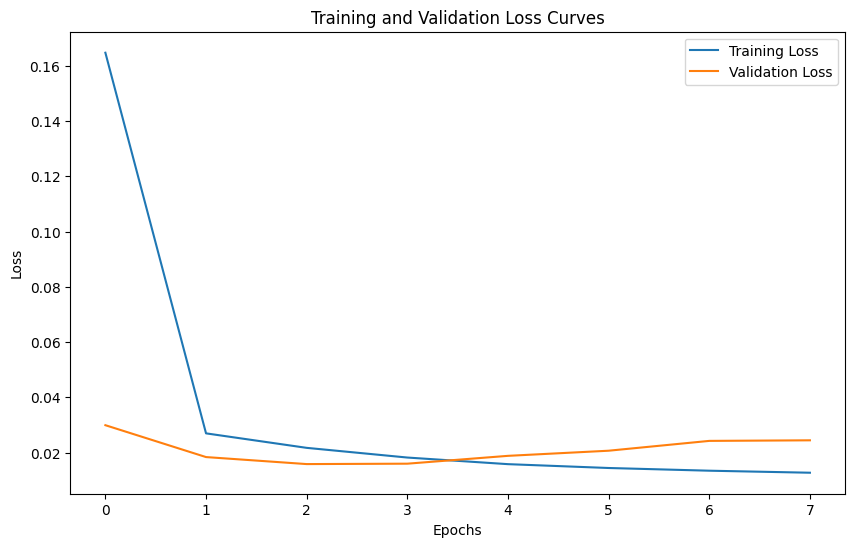

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/1000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/1000/assets


1/1 [==============================] - 0s 66ms/step
Metrics for delta_T_depth = 0.5m:
Average Precision: 0.78
Average Recall: 0.78
Average F1 Score: 0.78
----------
Metrics for delta_T_depth = 1m:
Average Precision: 0.82
Average Recall: 0.82
Average F1 Score: 0.82
----------
Metrics for delta_T_depth = 2m:
Average Precision: 0.88
Average Recall: 0.88
Average F1 Score: 0.88
----------
Metrics for delta_T_depth = 3m:
Average Precision: 0.9
Average Recall: 0.9
Average F1 Score: 0.9
----------
Metrics for delta_T_depth = 6m:
Average Precision: 0.96
Average Recall: 0.96
Average F1 Score: 0.96
----------
starting trainging for formation: 2000
Epoch 1/200
Training Loss: 0.21335, Validation Loss: 0.03535
Epoch 2/200
Training Loss: 0.02732, Validation Loss: 0.02270
Epoch 3/200
Training Loss: 0.02155, Validation Loss: 0.01727
Epoch 4/200
Training Loss: 0.01820, Validation Loss: 0.01357
Epoch 5/200
Training Loss: 0.01495, Validation Loss: 0.01704
Epoch 6/200
Training Loss: 0.01358, Validation Los

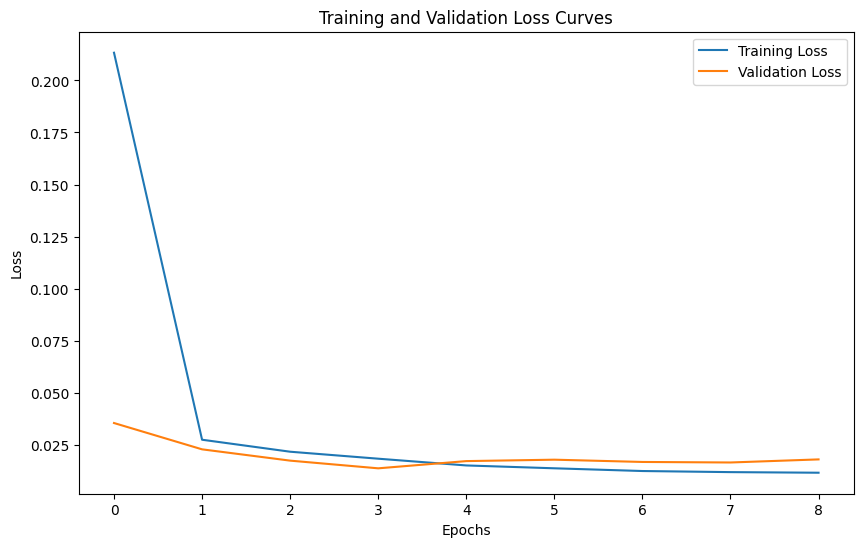

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/2000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/2000/assets


1/1 [==============================] - 0s 59ms/step
Metrics for delta_T_depth = 0.5m:
Average Precision: 0.62
Average Recall: 0.62
Average F1 Score: 0.62
----------
Metrics for delta_T_depth = 1m:
Average Precision: 0.76
Average Recall: 0.76
Average F1 Score: 0.76
----------
Metrics for delta_T_depth = 2m:
Average Precision: 0.86
Average Recall: 0.86
Average F1 Score: 0.86
----------
Metrics for delta_T_depth = 3m:
Average Precision: 0.88
Average Recall: 0.88
Average F1 Score: 0.88
----------
Metrics for delta_T_depth = 6m:
Average Precision: 0.9
Average Recall: 0.9
Average F1 Score: 0.9
----------
starting trainging for formation: 3000
Epoch 1/200
Training Loss: 0.23491, Validation Loss: 0.03266
Epoch 2/200
Training Loss: 0.02903, Validation Loss: 0.02386
Epoch 3/200
Training Loss: 0.02454, Validation Loss: 0.01964
Epoch 4/200
Training Loss: 0.02232, Validation Loss: 0.01726
Epoch 5/200
Training Loss: 0.02063, Validation Loss: 0.01591
Epoch 6/200
Training Loss: 0.01935, Validation Los

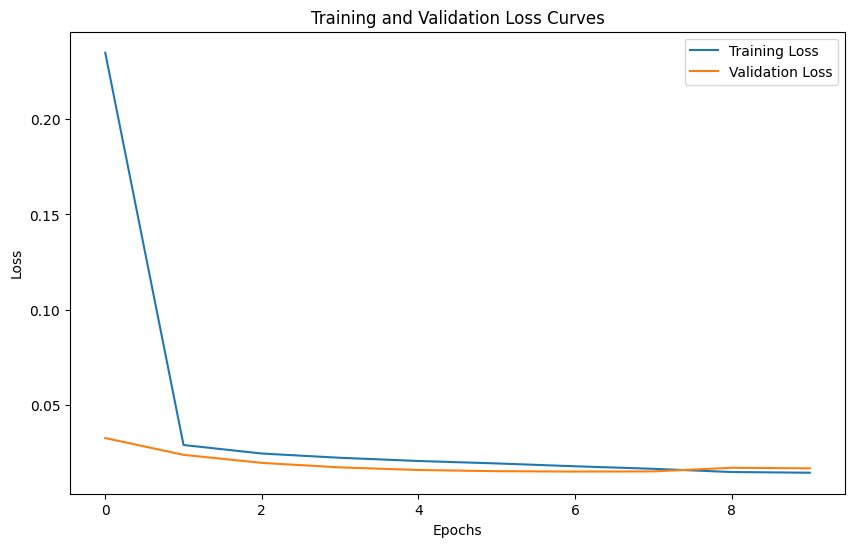

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/3000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/3000/assets


1/1 [==============================] - 0s 66ms/step
Metrics for delta_T_depth = 0.5m:
Average Precision: 0.38
Average Recall: 0.38
Average F1 Score: 0.38
----------
Metrics for delta_T_depth = 1m:
Average Precision: 0.6
Average Recall: 0.6
Average F1 Score: 0.6
----------
Metrics for delta_T_depth = 2m:
Average Precision: 0.74
Average Recall: 0.74
Average F1 Score: 0.74
----------
Metrics for delta_T_depth = 3m:
Average Precision: 0.86
Average Recall: 0.86
Average F1 Score: 0.86
----------
Metrics for delta_T_depth = 6m:
Average Precision: 0.92
Average Recall: 0.92
Average F1 Score: 0.92
----------
starting trainging for formation: 4000
Epoch 1/200
Training Loss: 0.24797, Validation Loss: 0.03293
Epoch 2/200
Training Loss: 0.02848, Validation Loss: 0.02473
Epoch 3/200
Training Loss: 0.02424, Validation Loss: 0.02246
Epoch 4/200
Training Loss: 0.02159, Validation Loss: 0.01967
Epoch 5/200
Training Loss: 0.01961, Validation Loss: 0.01803
Epoch 6/200
Training Loss: 0.01810, Validation Los

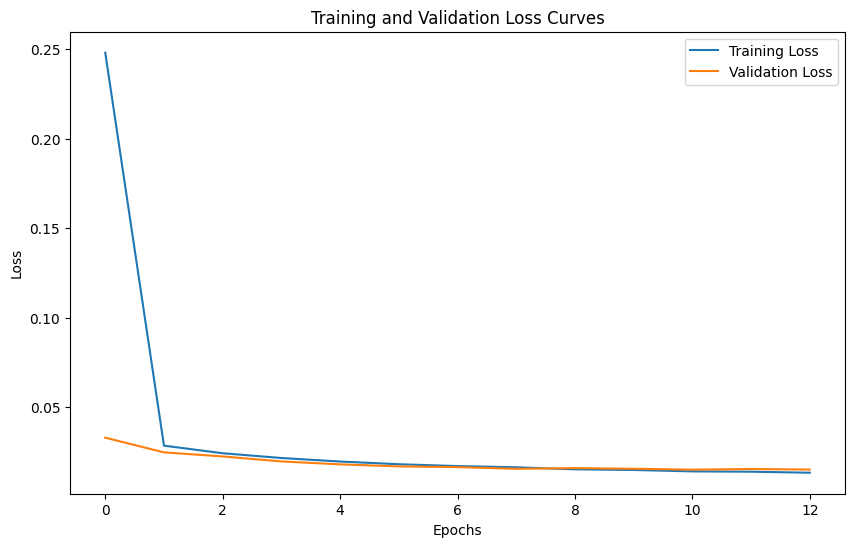

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/4000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/4000/assets


1/1 [==============================] - 0s 57ms/step
Metrics for delta_T_depth = 0.5m:
Average Precision: 0.34
Average Recall: 0.34
Average F1 Score: 0.34
----------
Metrics for delta_T_depth = 1m:
Average Precision: 0.44
Average Recall: 0.44
Average F1 Score: 0.44
----------
Metrics for delta_T_depth = 2m:
Average Precision: 0.64
Average Recall: 0.64
Average F1 Score: 0.64
----------
Metrics for delta_T_depth = 3m:
Average Precision: 0.68
Average Recall: 0.68
Average F1 Score: 0.68
----------
Metrics for delta_T_depth = 6m:
Average Precision: 0.76
Average Recall: 0.76
Average F1 Score: 0.76
----------
starting trainging for formation: 5000
Epoch 1/200
Training Loss: 0.20594, Validation Loss: 0.03490
Epoch 2/200
Training Loss: 0.02895, Validation Loss: 0.02821
Epoch 3/200
Training Loss: 0.02477, Validation Loss: 0.02544
Epoch 4/200
Training Loss: 0.02238, Validation Loss: 0.02198
Epoch 5/200
Training Loss: 0.02063, Validation Loss: 0.01973
Epoch 6/200
Training Loss: 0.01952, Validation 

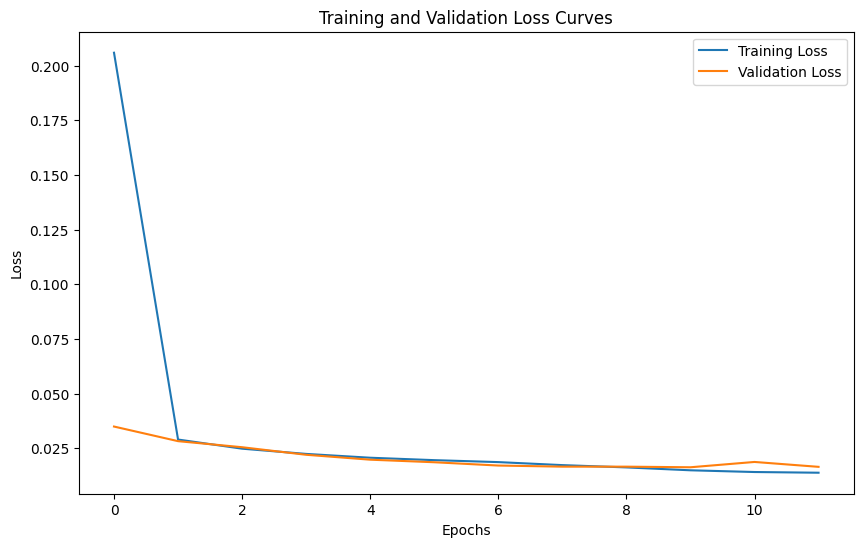

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/5000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/5000/assets


1/1 [==============================] - 0s 51ms/step
Metrics for delta_T_depth = 0.5m:
Average Precision: 0.28
Average Recall: 0.28
Average F1 Score: 0.28
----------
Metrics for delta_T_depth = 1m:
Average Precision: 0.46
Average Recall: 0.46
Average F1 Score: 0.46
----------
Metrics for delta_T_depth = 2m:
Average Precision: 0.6
Average Recall: 0.6
Average F1 Score: 0.6
----------
Metrics for delta_T_depth = 3m:
Average Precision: 0.66
Average Recall: 0.66
Average F1 Score: 0.66
----------
Metrics for delta_T_depth = 6m:
Average Precision: 0.78
Average Recall: 0.78
Average F1 Score: 0.78
----------
starting trainging for formation: 6000
Epoch 1/200
Training Loss: 0.22791, Validation Loss: 0.03496
Epoch 2/200
Training Loss: 0.02909, Validation Loss: 0.02352
Epoch 3/200
Training Loss: 0.02271, Validation Loss: 0.01864
Epoch 4/200
Training Loss: 0.01931, Validation Loss: 0.01540
Epoch 5/200
Training Loss: 0.01694, Validation Loss: 0.01322
Epoch 6/200
Training Loss: 0.01505, Validation Los

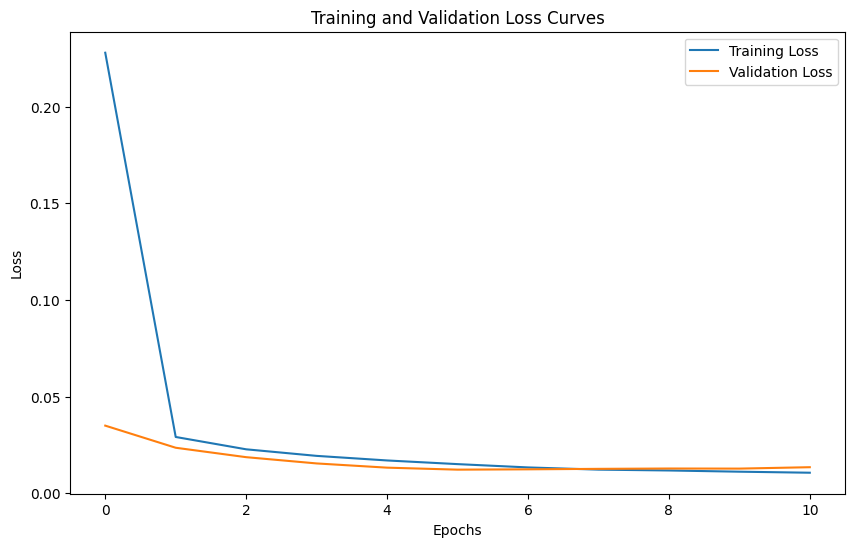

INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/6000/assets


INFO:tensorflow:Assets written to: c:\Users\nicholas.bivens_geot\school\TopPrediction/Model/6000/assets


In [323]:
# Initialize dictionaries to store metrics for each formation and delta_T
recall_metrics = {0.5: [], 1: [], 2: [], 3: [], 6: []}
precision_metrics = {0.5: [], 1: [], 2: [], 3: [], 6: []}
f1_metrics = {0.5: [], 1: [], 2: [], 3: [], 6: []}

models_list=[]
model_metrics = {}

# formations = ['2000','4000','5000','6000','12000','13000']

for formation in formations:
    print(f"starting trainging for formation: {formation}")
    # get training data
    formation_train_data = folder_path+f'{formation}/train/'
    X_train, y_train,X_val, y_val = get_train_data(formation_train_data) 
    # train model at depth
    model = train_model(X_train, y_train,X_val, y_val, learning_rate = 0.001,epochs=200, nodes=16 , dropout = 0.5, dilation3x3=32, dilation5x5=24,dilation7x7=0)
    models_list.append(model)
    current_dir = os.getcwd()
    model_path = current_dir + f"/Model/{formation}/"
    os.makedirs(model_path, exist_ok=True)
    model.save(model_path)
    
    # get test data
    formation_test_data = folder_path+f'/{formation}/test/'
    X_test, y_test, test_dfs = get_test_data(formation_test_data)
    
    # make predictions
    for i, df in enumerate(test_dfs):
        make_predictions(df,X_test[i],y_test[i], model, formation_test_data)
    
    model_deltaT_metrics= evaluate_model(test_dfs)
    # Store metrics for each delta_T
    for delta_T, metrics in model_deltaT_metrics.items():
        recall_metrics[delta_T].append(metrics['average_recall'])
        precision_metrics[delta_T].append(metrics['average_precision'])
        f1_metrics[delta_T].append(metrics['average_f1'])
        
# Convert dictionaries to pandas DataFrames
recall_df = pd.DataFrame(recall_metrics, index=formations)
precision_df = pd.DataFrame(precision_metrics, index=formations)
f1_df = pd.DataFrame(f1_metrics, index=formations)

In [ ]:
def style_dataframe(df, title):
    styled_df = df.style.set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'Black'), ('background-color', 'lightgrey')]},
         {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '11pt'), ('color', 'black')]},  # Text color set to black
         {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f2f2f2')]},
         {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'white')]},
         {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]},
         {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('margin', 'auto')]},
         {'selector': 'th, td', 'props': [('border', '1px solid black')]}]
    ).set_properties(**{'width': '100px', 'height': '30px'}).set_caption("Delta T")

    # Custom CSS for positioning the index and column labels
    styled_df = styled_df.set_table_styles([
        {'selector': 'thead', 'props': [('vertical-align', 'bottom'), ('text-align', 'center')]},
        {'selector': 'tbody', 'props': [('vertical-align', 'middle'), ('text-align', 'center')]},
        {'selector': '.index_name', 'props': [('text-align', 'center'), ('vertical-align', 'middle')]},
        {'selector': '.col_heading', 'props': [('text-align', 'center'), ('vertical-align', 'bottom')]}
    ], overwrite=False, axis=0)

    return styled_df

# Apply styling to the DataFrames with titles
styled_recall_df = style_dataframe(recall_df, "Recall")
styled_precision_df = style_dataframe(precision_df, "Precision")
styled_f1_df = style_dataframe(f1_df, "F1")

# Display the styled DataFrames
display(styled_recall_df)
display(styled_precision_df)
display(styled_f1_df)


,0.5,1.0,2.0,3.0,6.0
1000,0.700000,0.760000,0.780000,0.820000,0.900000
2000,0.520000,0.700000,0.820000,0.840000,0.880000
3000,0.380000,0.540000,0.660000,0.740000,0.840000
4000,0.280000,0.440000,0.580000,0.640000,0.660000
5000,0.260000,0.420000,0.520000,0.580000,0.740000
6000,0.520000,0.700000,0.800000,0.860000,0.920000
7000,0.580000,0.760000,0.900000,0.920000,0.960000
9000,0.280000,0.400000,0.480000,0.680000,0.880000
9500,0.180000,0.420000,0.620000,0.740000,0.880000
10000,0.440000,0.600000,0.780000,0.820000,0.860000


,0.5,1.0,2.0,3.0,6.0
1000,0.700000,0.760000,0.780000,0.820000,0.900000
2000,0.520000,0.700000,0.820000,0.840000,0.880000
3000,0.380000,0.540000,0.660000,0.740000,0.840000
4000,0.280000,0.440000,0.580000,0.640000,0.660000
5000,0.260000,0.420000,0.520000,0.580000,0.740000
6000,0.520000,0.700000,0.800000,0.860000,0.920000
7000,0.580000,0.760000,0.900000,0.920000,0.960000
9000,0.280000,0.400000,0.480000,0.680000,0.880000
9500,0.180000,0.420000,0.620000,0.740000,0.880000
10000,0.440000,0.600000,0.780000,0.820000,0.860000


,0.5,1.0,2.0,3.0,6.0
1000,0.700000,0.760000,0.780000,0.820000,0.900000
2000,0.520000,0.700000,0.820000,0.840000,0.880000
3000,0.380000,0.540000,0.660000,0.740000,0.840000
4000,0.280000,0.440000,0.580000,0.640000,0.660000
5000,0.260000,0.420000,0.520000,0.580000,0.740000
6000,0.520000,0.700000,0.800000,0.860000,0.920000
7000,0.580000,0.760000,0.900000,0.920000,0.960000
9000,0.280000,0.400000,0.480000,0.680000,0.880000
9500,0.180000,0.420000,0.620000,0.740000,0.880000
10000,0.440000,0.600000,0.780000,0.820000,0.860000


In [ ]:
# current_dir = os.getcwd()
# # Train your model here
# model_path = current_dir + "/Model/"

# # Load the model
# loaded_model = load_model(model_path, )

In [ ]:
# # Assuming y_test is a list of 2D arrays with shape (n, 1)
# y_test_smoothed = [smooth_labels(y, sigma=2) for y in y_test]

# # Example usage
# z_test = y_test[0].flatten()  # Flatten the array to 1D
# smoothed_z_test = smooth_labels(z_test, sigma=2) # Flatten the smoothed labels to 1D

# # Plot the results
# plt.plot(y_test[0], label='Original Labels')
# plt.plot(y_test_smoothed[0], label='Smoothed Labels')
# plt.legend()
# plt.show()

# # Define the range around the pick to focus on
# focus_index = 15  # Index of the pick
# range_around_pick = 10  # Number of indices to include on either side

# # Plot the results focusing on the specified range
# plt.figure(figsize=(10, 5))  # Increase figure size for better visibility
# plt.plot(range(focus_index - range_around_pick, focus_index + range_around_pick + 1),
#          y_test[0][focus_index - range_around_pick:focus_index + range_around_pick + 1],
#          label='Original Labels')
# plt.plot(range(focus_index - range_around_pick, focus_index + range_around_pick + 1),
#          y_test_smoothed[0][focus_index - range_around_pick:focus_index + range_around_pick + 1],
#          label='Smoothed Labels')
# plt.legend()
# plt.title(f"Labels around index {focus_index}")
# plt.xlabel("Index")
# plt.ylabel("Label Value")
# plt.show()

# print(max(y_test[0]))